<a href="https://colab.research.google.com/github/ahmedimf1/DataScience/blob/master/LSTM_Stock_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web

from datetime import timedelta
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")

!pip install ta
# Technical Analysis library
import ta

# Neural Network library
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import datetime


In [ ]:
end = datetime.datetime.now()
start = datetime.datetime(end.year-5, end.month, end.day)

# SPDR = input("URL For SPDR data")
# #go to https://finance.yahoo.com/quote/SPY/history?p=SPY and copy the download-link of the data


In [ ]:
spdr = web.DataReader("spy", 'yahoo', start, end)
spdr

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-02-08,186.119995,182.800003,185.770004,185.419998,191526700.0,168.349808
2016-02-09,186.940002,183.199997,183.360001,185.429993,184513100.0,168.358871
2016-02-10,188.339996,185.119995,186.410004,185.270004,148214100.0,168.213638
2016-02-11,184.100006,181.089996,182.339996,182.860001,219058900.0,166.025482
2016-02-12,186.649994,183.960007,184.960007,186.630005,127632400.0,169.448425
...,...,...,...,...,...,...
2021-02-01,377.339996,370.380005,373.720001,376.230011,75817600.0,376.230011
2021-02-02,383.220001,376.320007,379.649994,381.549988,64450700.0,381.549988
2021-02-03,383.700012,380.480011,382.440002,381.850006,52427100.0,381.850006


In [ ]:
## Datetime conversion
spdr['Date'] = pd.to_datetime(spdr.index)

# Setting the index
spdr.set_index('Date', inplace=True)

# Dropping any NaNs
spdr.dropna(inplace=True)



## Technical Indicators

# Adding all the indicators
spdr = ta.add_all_ta_features(spdr, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Dropping everything else besides 'Close' and the Indicators
spdr.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

# Only using the last 1000 days of data to get a more accurate representation of the current market climate
df = spdr.tail(1000)



## Scaling

# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()

close_scaler.fit(df[['Close']])

# Normalizing/Scaling the DF
scaler = RobustScaler()

spdr = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
spdr.head()

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,Close,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_adx,...,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,trend_stc,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-02-16,-1.119520,-1.330284,-1.151500,1.241745,0.452516,0.629888,-0.023529,0.069156,0.272077,-0.568371,-1.199684,-0.523727,-1.244708,-1.267948,-1.229340,-0.140403,0.570303,0.0,0.0,-1.151998,-1.242422,-1.113121,-0.360106,1.218905,1.0,0.0,-1.204648,-1.230013,-1.264411,-0.212761,0.329838,-0.214948,0.132742,-0.023948,0.588585,-1.176002,-1.278952,-1.167711,-1.313257,0.064699,...,0.734207,0.031846,-0.057631,0.680637,-0.608372,-0.027009,-0.188724,0.545704,-1.138151,-1.295796,-1.205863,-1.372609,-1.328945,-1.663687,0.272727,-0.071429,0.192308,-1.119043,-1.292139,0.0,0.0,0.298734,1.152057,0.442532,0.610233,0.660376,0.795915,1.365929,0.369137,0.435331,0.369137,0.206042,-1.116977,0.697294,0.089899,-0.292588,0.698330,-0.181289,-0.181558,-1.119520
2017-02-17,-1.110631,-1.300283,-1.070811,1.480087,0.427490,1.026150,-0.076362,0.213545,-0.076519,-0.566845,-1.185834,-0.532910,-1.234374,-1.250995,-1.227084,-0.069608,0.492222,0.0,0.0,-1.139101,-1.228825,-1.100393,-0.357974,1.124202,1.0,0.0,-1.204648,-1.230013,-1.264411,-0.214538,0.415703,-0.246771,0.175699,0.024519,0.579899,-1.161432,-1.271182,-1.154858,-1.302302,0.238787,...,1.127537,0.091626,-0.073286,0.490316,-0.689344,0.033580,-0.155635,0.635529,-1.138151,-1.295796,-1.205863,-1.356585,-1.321495,-1.663687,0.363636,-0.142857,0.269231,-1.098274,-1.292139,0.0,0.0,0.312132,1.205689,0.496255,0.594934,0.642805,0.892838,1.555404,0.460043,0.430370,0.460043,0.255221,-1.102166,0.739348,0.151444,-0.210391,0.689410,0.090612,0.090636,-1.110631
2017-02-21,-1.076997,-1.277435,-0.977850,1.609157,0.612206,1.417612,0.229051,0.305950,0.556614,-0.566845,-1.167688,-0.525910,-1.221576,-1.231103,-1.223028,0.007016,0.598281,1.0,0.0,-1.122257,-1.210348,-1.084456,-0.339373,1.374636,1.0,0.0,-1.177931,-1.194662,-1.231490,-0.164448,0.387897,-0.285374,0.238650,0.076768,0.632737,-1.144424,-1.261496,-1.138852,-1.289404,0.447709,...,1.451914,0.156581,-0.053923,0.583394,-0.370593,0.119499,-0.111045,0.770003,-1.120496,-1.270921,-1.184775,-1.332136,-1.319954,-1.663687,0.363636,-0.214286,0.307692,-1.081658,-1.292139,0.0,0.0,0.318831,1.389420,0.536928,0.594934,0.625233,1.013742,1.622129,0.433233,0.433907,0.433233,0.301840,-1.075617,0.928142,0.315810,-0.103329,0.871681,0.581049,0.579940,-1.076997
2017-02-22,-1.082042,-1.270975,-1.042769,1.568126,0.474969,1.084506,-0.063335,0.251645,0.370554,-0.567706,-1.153253,-0.550486,-1.210833,-1.213842,-1.220269,0.076528,0.418827,0.0,0.0,-1.105844,-1.193810,-1.067521,-0.353610,0.992773,1.0,0.0,-1.176595,-1.194662,-1.230839,-0.171302,0.341204,-0.330381,0.273185,0.125961,0.590040,-1.130888,-1.252521,-1.126077,-1.277874,0.641708,...,1.372470,0.219277,-0.053778,0.409404,-0.626081,0.199909,-0.054112,0.849607,-1.109765,-1.270921,-1.178955,-1

Helper Functions

In [ ]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)
  
  
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass
          
          
def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))

Creating The Neural Network

In [ ]:
# How many periods looking back to learn
n_per_in  = 90
# How many periods to predict
n_per_out = 30
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [ ]:
# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=10, #changed
            n_nodes=30, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Fitting and Training
res = model.fit(X, y, epochs=50, batch_size=128, validation_split=0.1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 90, 90)            63000     
_________________________________________________________________
lstm_22 (LSTM)               (None, 90, 30)            14520     
_________________________________________________________________
lstm_23 (LSTM)               (None, 90, 30)            7320      
_________________________________________________________________
lstm_24 (LSTM)               (None, 90, 30)            7320      
_________________________________________________________________
lstm_25 (LSTM)               (None, 90, 30)            7320      
_________________________________________________________________
lstm_26 (LSTM)               (None, 90, 30)            7320      
_________________________________________________________________
lstm_27 (LSTM)               (None, 90, 30)           

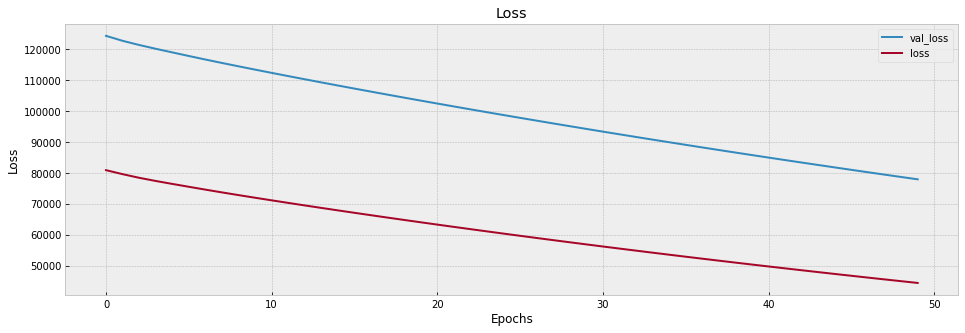

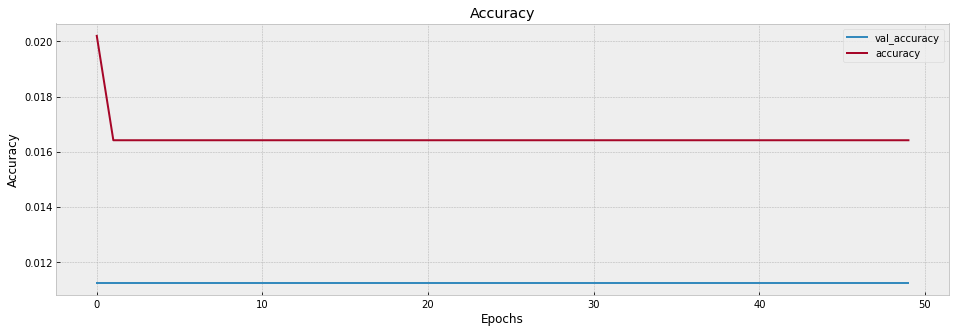

In [ ]:
visualize_training_results(res)

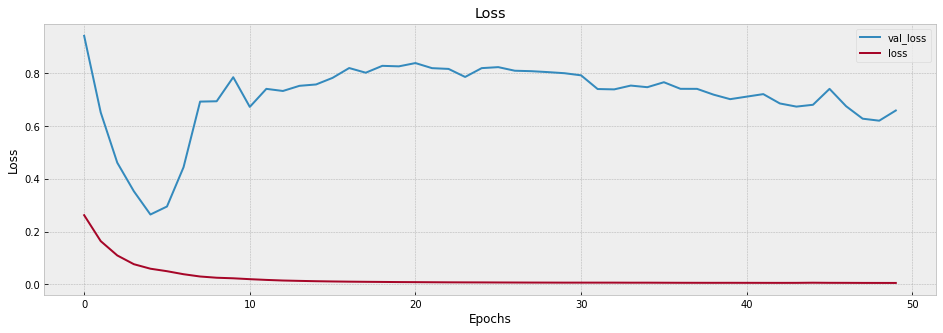

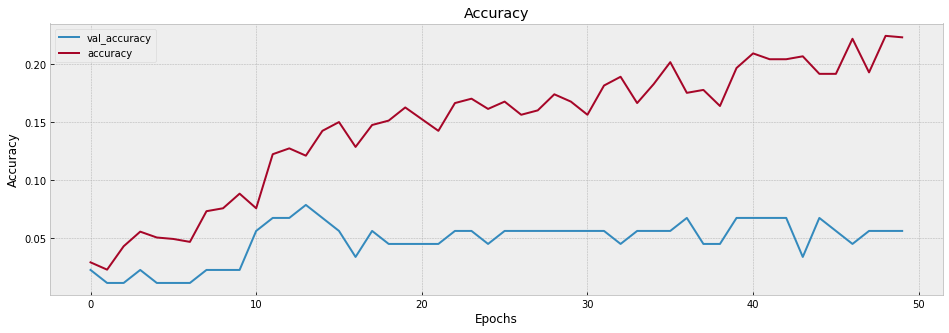

In [ ]:
visualize_training_results(res)

Model Validation

RMSE: 5.069747436251119


ConversionError: ignored

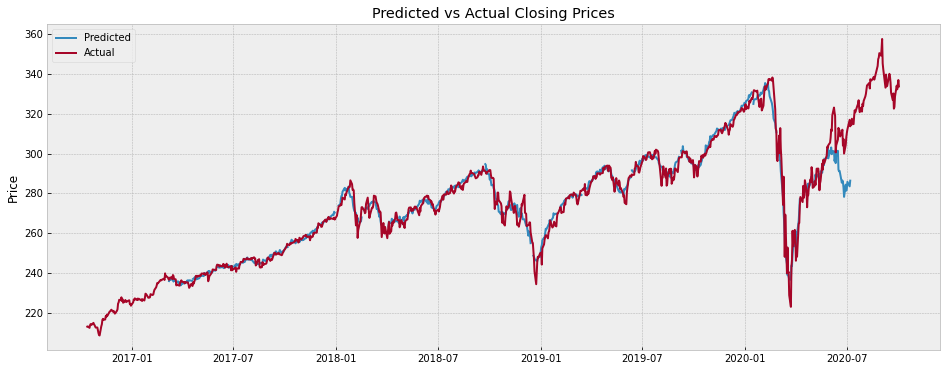

In [ ]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.xlim('2017-01', '2020-10')
plt.show()

Forecasting

                 Close
2020-10-05  324.941040
2020-10-06  326.075439
2020-10-07  325.324951
2020-10-08  327.397766
2020-10-09  325.323639
2020-10-12  325.977081
2020-10-13  327.095062
2020-10-14  325.502655
2020-10-15  329.790710
2020-10-16  330.019867
2020-10-19  331.361694
2020-10-20  330.415344
2020-10-21  330.423126
2020-10-22  327.799438
2020-10-23  331.148071
2020-10-26  329.913452
2020-10-27  328.182831
2020-10-28  329.052399
2020-10-29  326.234802
2020-10-30  325.211945
2020-11-02  322.270477
2020-11-03  322.671204
2020-11-04  322.739990
2020-11-05  318.601013
2020-11-06  316.857666
2020-11-09  315.094238
2020-11-10  314.894440
2020-11-11  311.730011
2020-11-12  310.441559
2020-11-13  304.081543


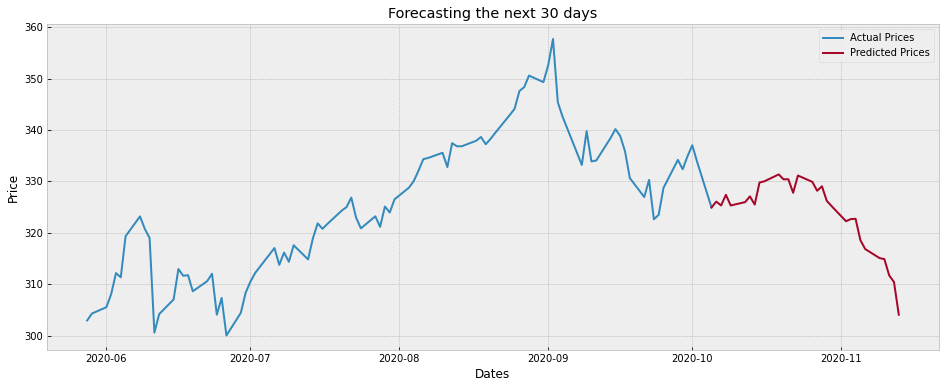

In [ ]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]].tail(pers)), 
                      index=df.Close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()